In [2]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import agent
import cliffworld_env
from tqdm import tqdm
import pickle

In [3]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

In [4]:
### Q-LEARNING AGENT
class QLearningAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """
        Input (args):
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        """
        
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        self.q = np.zeros((self.num_states, self.num_actions)) 
        
    def agent_start(self, state):
        """
        Input (args):
            state (int): the state from the environment's evn_start function.
        Output (returns):
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """
        Input (args):
            reward (float): the reward received for taking the last action taken
            state (int): the state from the environment's step based on where the agent ended up after the last step.
        Output (returns):
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * np.max(current_q) - self.q[self.prev_state, self.prev_action])
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """
        Input (args):
            reward (float): the reward the agent received for entering the terminal state.
        """
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])
        
    def argmax(self, q_values):
        """
        Input (args):
            q_values (Numpy array): the array of action-values
        Output (returns):
            action (int): an action with the highest value
        """
        
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [9]:
### Test method agent_start()

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)
action = current_agent.agent_start(0)
print("Action Value Estimates: \n", current_agent.q)
print("Action:", action)

Action Value Estimates: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Action: 1


In [10]:
### Test method agent_step() 

actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
actions.append(current_agent.agent_step(0, 0))
print("Action Value Estimates: \n", current_agent.q)
print("Actions:", actions)

Action Value Estimates: 
 [[0.   0.2  0.   0.  ]
 [0.   0.   0.   0.02]
 [0.   0.   0.   0.  ]]
Actions: [np.int64(1), np.int64(3), np.int64(1)]


In [11]:
### Test method agent_end() 

actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
current_agent.agent_end(1)
print("Action Value Estimates: \n", current_agent.q)
print("Actions:", actions)

Action Value Estimates: 
 [[0.  0.2 0.  0. ]
 [0.  0.  0.  0.1]
 [0.  0.  0.  0. ]]
Actions: [np.int64(1), np.int64(3)]


In [12]:
class ExpectedSarsaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """
        Input (args):
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):
        """
        Input (args):
            state (int): the state from the
                environment's evn_start function.
        Output (returns):
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """
        Input (args):
            reward (float): the reward received for taking the last action taken
            state (int): the state from the environment's step based on where the agent ended up after the last step.
        Output (returns):
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        q_max = np.max(current_q)
        pi = np.ones(self.num_actions) * (self.epsilon / self.num_actions)
        pi += (current_q == q_max) * ((1 - self.epsilon) / np.sum(current_q == q_max))
        expectation = np.sum(current_q * pi)
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * expectation - self.q[self.prev_state, self.prev_action])
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """
        Input (args):
            reward (float): the reward the agent received for entering the terminal state.
        """

        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])
        
    def argmax(self, q_values):
        """
        Input (args):
            q_values (Numpy array): the array of action-values
        Output (returns):
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [13]:
### Test method agent_start() 

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = ExpectedSarsaAgent()
current_agent.agent_init(agent_info)
action = current_agent.agent_start(0)
print("Action Value Estimates: \n", current_agent.q)
print("Action:", action)

Action Value Estimates: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Action: 1


In [15]:
### Test method agent_step() 

actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = ExpectedSarsaAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
actions.append(current_agent.agent_step(0, 0))
print("Action Value Estimates: \n", current_agent.q)
print("Actions:", actions)

Action Value Estimates: 
 [[0.     0.2    0.     0.    ]
 [0.     0.     0.     0.0185]
 [0.     0.     0.     0.    ]]
Actions: [np.int64(1), np.int64(3), np.int64(1)]


In [16]:
### Test method agent_end() 

actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = ExpectedSarsaAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
current_agent.agent_end(1)
print("Action Value Estimates: \n", current_agent.q)
print("Actions:", actions)

Action Value Estimates: 
 [[0.  0.2 0.  0. ]
 [0.  0.  0.  0.1]
 [0.  0.  0.  0. ]]
Actions: [np.int64(1), np.int64(3)]


100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


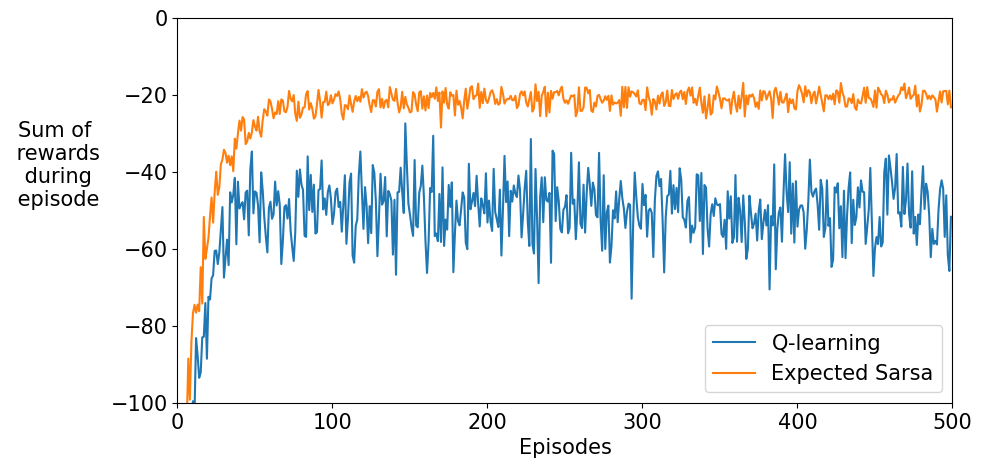

In [17]:
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 500 # The number of episodes in each run

for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# save results
import os
import shutil
os.makedirs('results', exist_ok=True)
np.save('results/q_learning.npy', all_reward_sums['Q-learning'])
np.save('results/expected_sarsa.npy', all_reward_sums['Expected Sarsa'])
shutil.make_archive('results', 'zip', '.', 'results')

        
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,500)
plt.ylim(-100,0)
plt.legend()
plt.show()

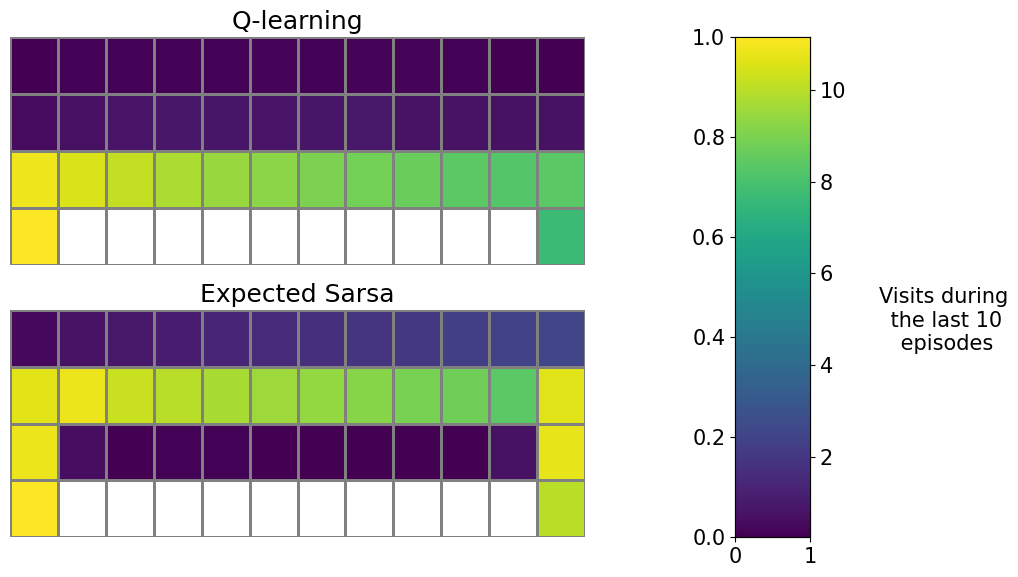

In [18]:
for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
    
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


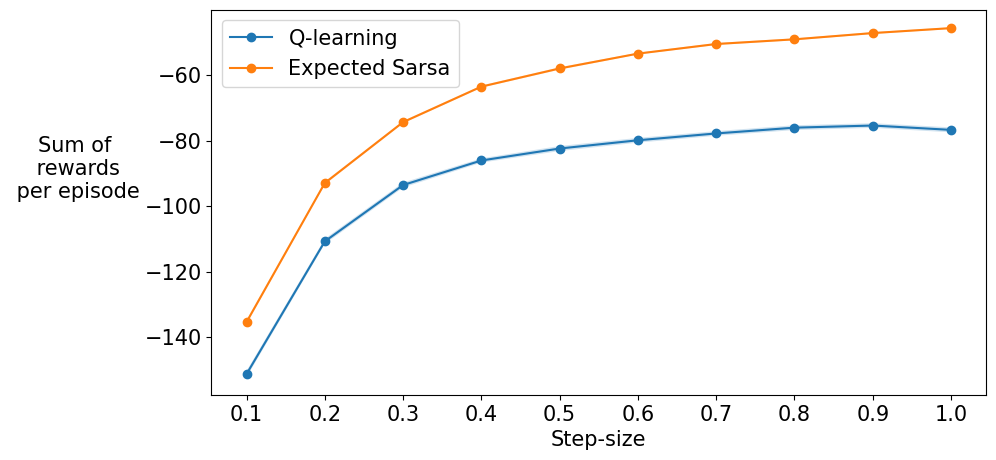

In [19]:
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 100
num_episodes = 100
all_reward_sums = {}

for algorithm in ["Q-learning", "Expected Sarsa"]:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        agent_info["step_size"] = step_size
        for run in tqdm(range(num_runs)):
            agent_info["seed"] = run
            rl_glue = RLGlue(env, agents[algorithm])
            rl_glue.rl_init(agent_info, env_info)

            return_sum = 0
            for episode in range(num_episodes):
                rl_glue.rl_episode(0)
                return_sum += rl_glue.rl_return()
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()